In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate, signal

from tqdm.notebook import tqdm, trange
from tqdm.keras import TqdmCallback

import pathlib, sys, os
from os import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, classification_report, confusion_matrix,accuracy_score,
                             precision_score, recall_score, f1_score,roc_auc_score, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

In [ ]:
# for new data:
data=data[data['Axis']!='t']
data.reset_index(drop=True, inplace=True)
full_data=data.copy()
data=data.iloc[:,:804]
n_seconds = 8
newfreq = 100

  0%|          | 0/165 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(165, 800, 49, 3)
True label: 48.5%


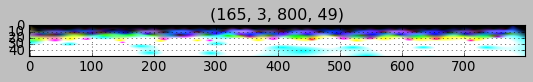

In [24]:
def moving_average(x, w = 20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype = np.float64),
                  (0,w), mode = 'constant')


# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1,1)

X = data[np.arange(n)].values.reshape(-1, 3, n)
X = np.transpose(X, [0,2,1])

Xt = np.zeros((X.shape[0], 3, X.shape[1], 49))

# filtering using low-pass butterworth

for x in trange(X.shape[0]):
    for i in range(3):
        X[x][:,i] = signal.detrend(X[x][:,i])
        X[x][:,i] = moving_average(X[x][:,i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:,i], wavelet = signal.morlet2, widths = np.arange(1, 50)).T)

X = Xt


plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0,2,3,1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")


static_features_data= full_data.iloc[:,np.r_[2:4, 805:full_data.shape[1]]]
axis_mapping = {'x': 1, 'y': 2, 'z': 3}
static_features_data['Axis'] = static_features_data['Axis'].replace(axis_mapping)
static_features_array = static_features_data.values

# Determine the number of features
num_features = static_features_array.shape[1]

# Calculate the number of subjects based on the number of rows
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 3

# Reshape the data
static_features = static_features_array.reshape(num_subjects, 3, num_features)

# building the model

In [86]:
Xt = np.transpose(Xt, (0, 2, 3, 1))
def init_model():
    cwt_inputs = keras.Input(shape = X.shape[1:], name='cwt_input')    
    x = cwt_inputs[:,:,0]
    y = cwt_inputs[:,:,1]
    z = cwt_inputs[:,:,2]
    
    x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPool1D(pool_size = 3)(x)        
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)        
    x = layers.Dense(4, activation = "relu")(x)
    
    y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
    y = layers.MaxPool1D(pool_size = 3)(y) 
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
    y = layers.Dense(4, activation = "relu")(y)
    
    z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
    z = layers.MaxPool1D(pool_size = 3)(z) 
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
    z = layers.Dense(4, activation = "relu")(z)
    cwt = layers.Flatten()(tf.concat([x,y,z], axis = 1))

    static_input = keras.Input(shape=static_features.shape[1:], name='static_input')
    static_processed = layers.Flatten()(static_input)
    static_processed = layers.Dense(64, activation="relu")(static_processed)
    static_processed = layers.Dropout(0.5)(static_processed)
    # Flatten the static features
    static_processed = layers.Flatten()(static_processed)
    combined = layers.concatenate([cwt, static_processed])
    # Fully connected layers after concatenation
    outputs = layers.Dense(64, activation='relu')(combined)
    outputs = layers.Dense(1, activation='sigmoid')(outputs)
    
    
    model = keras.Model(inputs = [cwt_inputs,static_input], outputs = outputs)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(loss="binary_crossentropy",
                  optimizer = optimizer,
                  metrics = [tf.keras.metrics.AUC(curve = 'ROC')]

                  )
    
    return model


model = init_model()
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cwt_input (InputLayer)      [(None, 800, 49, 3)]         0         []                            
                                                                                                  
 tf.__operators__.getitem_5  (None, 800, 3)               0         ['cwt_input[0][0]']           
 7 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_5  (None, 800, 3)               0         ['cwt_input[0][0]']           
 8 (SlicingOpLambda)                                                                              
                                                                                           

In [87]:
ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1,1)

In [96]:
# Assuming Xt is reshaped correctly and static_features is prepared
X = X.transpose(0,2,3,1)
epochs = 500
batch_size = 32
k = 5  # Number of folds

k_fold = KFold(n_splits=k, shuffle=True)
results = []

for fold, (train_idx, test_idx) in enumerate(k_fold.split(Xt)): 
    print(f"Training on fold {fold+1}...")

    train_dataset = tf.data.Dataset.from_tensor_slices(
        ({'cwt_input': Xt[train_idx], 'static_input': static_features[train_idx]}, y[train_idx])
    ).shuffle(buffer_size=1024).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        ({'cwt_input': Xt[test_idx], 'static_input': static_features[test_idx]}, y[test_idx])
    ).batch(batch_size)

    model = init_model()

    checkpoint_path = f"best_model_fold_{fold+1}.h5"

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
    ]


    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluation part remains the same
    predictions = (model.predict(test_dataset) > 0.5).astype(int)
    y_true = np.array([y for _, y in test_dataset.unbatch()])
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    roc_auc = roc_auc_score(y_true, predictions)

    print(f"Fold {fold+1}: Precision={precision:.4f}, Recall={recall:.4f}, ROC-AUC={roc_auc:.4f}")
    results.append((precision, recall, roc_auc))

avg_precision = np.mean([result[0] for result in results])
avg_recall = np.mean([result[1] for result in results])
avg_roc_auc = np.mean([result[2] for result in results])
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average ROC-AUC: {avg_roc_auc:.4f}")


Training on fold 1...


ValueError: Exception encountered when calling layer "max_pooling1d_185" (type MaxPooling1D).

Negative dimension size caused by subtracting 3 from 1 for '{{node max_pooling1d_185/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 3, 1, 1], padding="VALID", strides=[1, 3, 1, 1]](max_pooling1d_185/ExpandDims)' with input shapes: [?,1,1,8].

Call arguments received by layer "max_pooling1d_185" (type MaxPooling1D):
  • inputs=tf.Tensor(shape=(None, 1, 8), dtype=float32)

# Functions

In [78]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def fetch(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'vig',	'mod', 'walk',	'IPAQ_activity',	'IPAQ_sitting', 'BriefBESTest', 'height',	'weight', 'bmi', 'Axis'] + list(range(freq * n_seconds))]

    return output

# Reading subjects age data

,Subject,Age,Gender,vig,mod,walk,IPAQ_activity,IPAQ_sitting,BriefBESTest,height,...,790,791,792,793,794,795,796,797,798,799
0,1017,55,1,0,0,120,396.0,3780,19,170,...,-2.004609,-1.981167,-1.957724,-1.934281,-1.910839,-1.887396,-1.863953,0.782453,1.016410,1.09
1,1017,55,1,0,0,120,396.0,3780,19,170,...,-3.390000,-3.390000,-3.390000,-3.390000,-3.390000,-3.390000,-3.390000,-0.022037,0.154391,0.09
2,1017,55,1,0,0,120,396.0,3780,19,170,...,-3.272848,-3.377038,-3.481227,-3.585417,-3.689606,-3.793796,-3.897986,-1.857492,-0.830261,0.20
3,1017,55,1,0,0,120,396.0,3780,19,170,...,5.117709,5.180223,5.242736,5.305250,5.367764,5.430278,5.492791,2.025334,1.349168,1.11
4,1021,45,1,0,0,30,99.0,5040,20,173,...,0.817021,0.829292,0.841563,0.853833,0.866104,0.878374,0.969402,2.167291,2.217808,2.20
5,1021,45,1,0,0,30,99.0,5040,20,173,...,-1.891894,-1.888212,-1.884531,-1.880850,-1.877169,-1.873488,-1.758837,0.744860,0.765754,0.65
6,1021,45,1,0,0,30,99.0,5040,20,173,...,-1.296489,-1.290354,-1.284219,-1.278083,-1.271948,-1.265813,-1.207065,0.043924,-0.003288,-0.03
7,1021,45,1,0,0,30,99.0,5040,20,173,...,2.427298,2.426071,2.424844,2.423617,2.422390,2.421163,2.340598,2.288506,2.343425,2.29


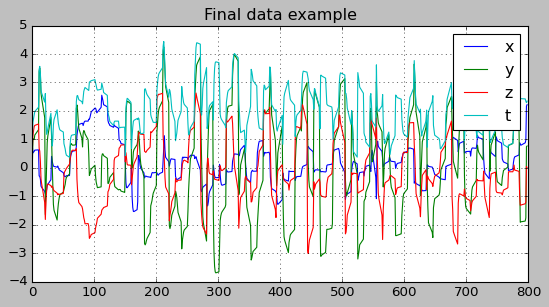

In [ ]:
# # we get four lines per subject - representing the accelerometer's x, y,z and T components.
# display(data.head(8))

# # and we can see an example
# d = data[data['Subject'] == subjects[1]]  # Selecting data for the first subject
# d.loc[:, np.arange(data.columns[-1])].T.plot()
# plt.legend(labels=['x', 'y', 'z', 't'])
# plt.title('Final data example')
# plt.show()

In [84]:
# for new data:
data=data[data['Axis']!='t']
data.reset_index(drop=True, inplace=True)
full_data=data.copy()
data=data.iloc[:,:813]
n_seconds = 8
newfreq = 100

  0%|          | 0/27 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(27, 800, 49, 3)
True label: 59.3%


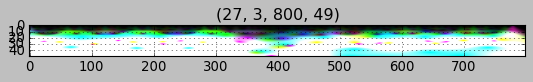

In [85]:
def moving_average(x, w = 20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype = np.float64),
                  (0,w), mode = 'constant')


# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data.loc[np.arange(0, len(data), 3), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1,1)

X = data[np.arange(n)].values.reshape(-1, 3, n)
X = np.transpose(X, [0,2,1])

Xt = np.zeros((X.shape[0], 3, X.shape[1], 49))

# filtering using low-pass butterworth

for x in trange(X.shape[0]):
    for i in range(3):
        X[x][:,i] = signal.detrend(X[x][:,i])
        X[x][:,i] = moving_average(X[x][:,i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:,i], wavelet = signal.morlet2, widths = np.arange(1, 50)).T)

X = Xt


plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0,2,3,1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")


static_features_data= full_data.iloc[:,np.r_[2:13, 814:full_data.shape[1]]]
axis_mapping = {'x': 1, 'y': 2, 'z': 3}
static_features_data['Axis'] = static_features_data['Axis'].replace(axis_mapping)
static_features_array = static_features_data.values

# Determine the number of features
num_features = static_features_array.shape[1]

# Calculate the number of subjects based on the number of rows
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 3

# Reshape the data
static_features = static_features_array.reshape(num_subjects, 3, num_features)

In [95]:
X = X.transpose(0,2,3,1)
print(Xt.shape)
print(X.shape)
# expected shape=(None, 49, 3, 800)

(27, 800, 49, 3)
(27, 49, 3, 800)
